In [1]:
import pickle
import os
from tqdm import tqdm
import numpy as np

directory = 'data/train'

length_list = []
valence_values=[]

recordings = []

for filename in tqdm(os.listdir(directory)):
    if filename.endswith('.pkl'):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            if data['valence'] != 2.333: #and len(data['audio_data']) < 91000:
                length_list.append(len(data['audio_data']))
                valence_values.append(data['valence'])
                recordings.append(data['audio_data'])

valence_values = np.array(valence_values)
len(recordings)

100%|██████████| 10557/10557 [00:05<00:00, 1768.61it/s]


10556

In [2]:
# Calculate the maximum length
max_length = max(length_list)

# Adjust the recordings to have the same length
adjusted_recordings = []
for recording in recordings:
    # Repeat the array until it reaches or exceeds the maximum length
    repeated_recording = np.tile(recording, (max_length // len(recording) + 1))[:max_length]
    adjusted_recordings.append(repeated_recording)

valence_values = np.array(valence_values)
len(adjusted_recordings), adjusted_recordings[0].shape


# for i in adjusted_recordings:
#     print(i.shape)

(10556, (174625,))

In [3]:
def round_to_nearest_quarter(number):
    # Assuming 'number' could be a numpy array with a single value
    if isinstance(number, np.ndarray) and number.size == 1:
        number = number.item()  # Convert single-item array to scalar
    
    # Ensure the number is within the 1 to 5 range before processing
    number = np.clip(number, 1, 5)
    # Scale number to shift quarters to whole numbers, round, and rescale
    rounded_number = np.round(number * 4) / 4
    # Clip again to ensure no out-of-range values after rounding
    rounded_number = np.clip(rounded_number, 1, 5)
    return str(rounded_number)

# Pre-process data

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


############################################################################################################
# Standardize the recordings (not used in this example)
# standard = StandardScaler()
# adjusted_recordings = standard.fit_transform(adjusted_recordings)
#print(adjusted_recordings)

############################################################################################################
# Pad the recordings to have the same length
max_length = max(len(array) for array in recordings)  # Find the maximum length

### Padding with zeros
# # Pad each array to have the maximum length
# padded_arrays = np.array([np.pad(array, (0, max_length - len(array)), mode='constant') for array in recordings])


############################################################################################################
# Split the data and labels into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(adjusted_recordings, valence_values, test_size=0.2, random_state=42)


############################################################################################################
# Create a DataLoader for the training set, test set, and validation set

batch_size = 256  

# Convert input data and labels to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)  # Use float32 for labels

# Create a dataset from tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)



############################################################################################################
# Validation set
X_validation_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_validation_tensor = torch.tensor(y_val, dtype=torch.float32)

validation_dataset = TensorDataset(X_validation_tensor, y_validation_tensor)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)




C:\Users\20211922\AppData\Local\Temp\ipykernel_27672\3858996454.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Use float32 for input features


In [5]:
train_loader.dataset.tensors[0].shape, train_loader.dataset.tensors[1].shape

(torch.Size([8444, 1, 174625]), torch.Size([8444]))

In [6]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torchaudio.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

models = {}


class ResidualBlock(nn.Module):
    def __init__(self, channels, kernel_size=7, dilation=2):
        super(ResidualBlock, self).__init__()


        padding = (kernel_size - 1) * dilation // 2  

        # 1st Convolutional Layer
        self.conv1 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(channels)
        self.relu = nn.ReLU(inplace=True)

        # 2nd Convolutional Layer
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(channels)

    def forward(self, x):
        residual = x  
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        #  addition of input to the output -- residual connection
        out += residual  
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Random seed for reproducibility
        torch.manual_seed(42)


        self.mfcc_transform = transforms.MFCC(
            sample_rate=8000,      ## 
            n_mfcc=24              ## Created channels
        )


        self.layers = nn.ModuleList()
        
        # Start with 1D BatchNorm
        self.layers.append(nn.BatchNorm1d(24))


        ###########################
        # 1st Convolutional Layer
        ###########################

        conv1 = nn.Conv1d(in_channels=24, out_channels=64, kernel_size=7, padding=1)
        # Initialize the weight using He initialization
        nn.init.kaiming_normal_(conv1.weight, nonlinearity='relu')
        self.layers.append(conv1)
        self.layers.append(nn.BatchNorm1d(64))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.3))

        ###########################
        # Residual Block
        ###########################
        self.layers.append(ResidualBlock(64))

        ###########################
        # 2nd Convolutional Layer
        ###########################
        
        conv2 = nn.Conv1d(in_channels=64, out_channels=48, kernel_size=7, padding=1)
        # He initialization
        nn.init.kaiming_normal_(conv2.weight, nonlinearity='relu')
        self.layers.append(conv2)
        self.layers.append(nn.BatchNorm1d(48))
        self.layers.append(nn.ReLU())

        ###########################
        # 3rd Convolutional Layer
        ###########################

        conv3 = nn.Conv1d(in_channels=48, out_channels=12, kernel_size=7, padding=1,dilation=2)
        # He initialization
        nn.init.kaiming_normal_(conv3.weight, nonlinearity='relu')
        self.layers.append(conv3)
        self.layers.append(nn.BatchNorm1d(12))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.MaxPool1d(kernel_size=3))
        self.layers.append(nn.Dropout(0.25))

        ###########################
        # Flatten
        ###########################
        self.layers.append(nn.Flatten())

        ###########################
        # 1st Fully Connected Layer
        ###########################

        linear1= nn.Linear(1104,256)
        nn.init.kaiming_normal_(linear1.weight, nonlinearity='relu')
        self.layers.append(linear1)
        self.layers.append(nn.ReLU())
        
        ###########################
        # 2nd Fully Connected Layer
        ###########################
        linear2 = nn.Linear(256, 1)
        nn.init.kaiming_normal_(linear2.weight, nonlinearity='relu')
        self.layers.append(linear2)




    
    def forward(self, x):
        x = self.mfcc_transform(x)
        x = x.squeeze(1)
        for layer in self.layers:
            x = layer(x)
            #print(x.shape)
        return x.view(-1)


### CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Training Cycle

def train_model(MLP_model, optimizer, num_epochs,save_dir = 'model_checkpoint/'):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        criterion = nn.MSELoss()
        # Training loop
        for epoch in tqdm(range(num_epochs)):
            MLP_model.train()
            total_loss = 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # To GPU
                outputs = MLP_model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute the loss
                loss.backward()  # Backward pass
                optimizer.step()
                total_loss += loss.item()
            
            # Print the loss every epoch
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if epoch > 1:
                # Set the model to evaluation mode and calculate the loss for the validation set
                MLP_model.eval() 
                val_eval = evaluate_model(MLP_model, validation_loader,conf=False)
                print(f'Validation: {val_eval}')
                # Set the model back to training mode
                MLP_model.train()
            print('--------------------------------------------------')

            # Save the model at each epoch using torch.save
            torch.save({
                'epoch': epoch,
                'model_state_dict': MLP_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
                    
        print(evaluate_model(MLP_model, train_loader,conf=True))



def evaluate_model(MLP_model, test_loader,conf=False):
    with torch.no_grad():

        ### Calculate MSE 
        predictions = []
        actuals = []
        actuals_for_cm = []
        rounded_predictions = []
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = MLP_model(inputs)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            actuals_for_cm.extend([str(label) for label in labels.cpu().numpy()])
            rounded_predictions.extend([str(round_to_nearest_quarter(output)) for output in outputs.cpu().numpy()])

        predictions = np.array(predictions)
        actuals = np.array(actuals)
        mse = np.mean((predictions - actuals) ** 2)
        mae = np.mean(np.abs(predictions - actuals))
        #print(f'Mean Squared Error: {mse:.4f} and Mean Absolute Error: {mae:.4f}')

        # for i in range(10):
        #     print(f"Predictions: {predictions[i]}")
        #     print(f"Actuals: {actuals[i]}")
        #     print(f"Rounded Predictions: {rounded_predictions[i]}")
        
        ##################
        # Confusion Matrix
        ##################
        if conf:
            ### Confusion Matrix
            cm = confusion_matrix(actuals_for_cm, rounded_predictions)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(actuals), yticklabels=np.unique(actuals))
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.show()
            ### Accuracy
            accuracy = np.trace(cm) / np.sum(cm)
            print(f'Accuracy: {accuracy:.4f}')
        return mse



############################################################################################################
### PREDICT
def predict(model, data, device):
    model.eval()  
    data = data.to(device)  
    with torch.no_grad(): 
        predictions = []
        for sample in data:
            sample = sample.unsqueeze(0)  
            output = model(sample)
            predictions.append(output.item())
    return predictions





            
        

        


In [7]:
# modelCNN = CNN().to(device)
# optimizer = optim.Adagrad(modelCNN.parameters(), lr=0.001, weight_decay=0.0001)
# train_model(modelCNN, optimizer, num_epochs=200)

In [8]:
# ############################################################################################################
# ### Load the model
# def load_model(epoch, save_dir='model_checkpoint'):
#     model = CNN()
#     optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=0.0001)  
#     checkpoint = torch.load(os.path.join(save_dir, f'model_epoch_{epoch}.pth'))
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     epoch = checkpoint['epoch']
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model = model.to(device)  
#     model.eval()
#     return model, optimizer, epoch


# loaded_epoch = 115  # Epoch to evaluate
# loaded_model, loaded_optimizer, loaded_epoch = load_model(loaded_epoch)

# # Evaluate the loaded model
# evaluate_model(loaded_model, validation_loader, conf=True)

  2%|▏         | 1/50 [00:29<24:18, 29.77s/it]

Epoch [1/50], Loss: 218.6098
--------------------------------------------------


  4%|▍         | 2/50 [00:43<16:16, 20.34s/it]

Epoch [2/50], Loss: 10.2590
--------------------------------------------------
Epoch [3/50], Loss: 9.8188


  6%|▌         | 3/50 [00:55<13:04, 16.69s/it]

Validation: 9.49350357055664
--------------------------------------------------
Epoch [4/50], Loss: 9.4264


  8%|▊         | 4/50 [01:05<10:37, 13.85s/it]

Validation: 9.142988204956055
--------------------------------------------------
Epoch [5/50], Loss: 9.1026


 10%|█         | 5/50 [01:14<09:13, 12.31s/it]

Validation: 8.847739219665527
--------------------------------------------------
Epoch [6/50], Loss: 8.8253


 12%|█▏        | 6/50 [01:24<08:19, 11.35s/it]

Validation: 8.590241432189941
--------------------------------------------------
Epoch [7/50], Loss: 8.5806


 14%|█▍        | 7/50 [01:33<07:41, 10.73s/it]

Validation: 8.360241889953613
--------------------------------------------------
Epoch [8/50], Loss: 8.3601


 16%|█▌        | 8/50 [01:43<07:14, 10.34s/it]

Validation: 8.151387214660645
--------------------------------------------------
Epoch [9/50], Loss: 8.1588


 18%|█▊        | 9/50 [01:52<06:54, 10.11s/it]

Validation: 7.9594502449035645
--------------------------------------------------
Epoch [10/50], Loss: 7.9725


 20%|██        | 10/50 [02:02<06:42, 10.06s/it]

Validation: 7.781421184539795
--------------------------------------------------
Epoch [11/50], Loss: 7.7996


 22%|██▏       | 11/50 [02:12<06:30, 10.01s/it]

Validation: 7.615062236785889
--------------------------------------------------
Epoch [12/50], Loss: 7.6368


 24%|██▍       | 12/50 [02:22<06:14,  9.86s/it]

Validation: 7.458741664886475
--------------------------------------------------
Epoch [13/50], Loss: 7.4840


 26%|██▌       | 13/50 [02:32<06:02,  9.81s/it]

Validation: 7.311085224151611
--------------------------------------------------
Epoch [14/50], Loss: 7.3396


 28%|██▊       | 14/50 [02:41<05:51,  9.76s/it]

Validation: 7.171044826507568
--------------------------------------------------
Epoch [15/50], Loss: 7.2016


 30%|███       | 15/50 [02:51<05:39,  9.69s/it]

Validation: 7.037785530090332
--------------------------------------------------
Epoch [16/50], Loss: 7.0706


 32%|███▏      | 16/50 [03:00<05:30,  9.71s/it]

Validation: 6.910592079162598
--------------------------------------------------
Epoch [17/50], Loss: 6.9453


 34%|███▍      | 17/50 [03:10<05:20,  9.70s/it]

Validation: 6.788877964019775
--------------------------------------------------
Epoch [18/50], Loss: 6.8254


 36%|███▌      | 18/50 [03:20<05:08,  9.64s/it]

Validation: 6.672121047973633
--------------------------------------------------
Epoch [19/50], Loss: 6.7101


 38%|███▊      | 19/50 [03:29<04:57,  9.60s/it]

Validation: 6.559919834136963
--------------------------------------------------
Epoch [20/50], Loss: 6.5992


 40%|████      | 20/50 [03:39<04:47,  9.60s/it]

Validation: 6.451882362365723
--------------------------------------------------
Epoch [21/50], Loss: 6.4924


 42%|████▏     | 21/50 [03:48<04:38,  9.59s/it]

Validation: 6.347679138183594
--------------------------------------------------
Epoch [22/50], Loss: 6.3891


 44%|████▍     | 22/50 [03:58<04:28,  9.57s/it]

Validation: 6.247034072875977
--------------------------------------------------
Epoch [23/50], Loss: 6.2894


 46%|████▌     | 23/50 [04:07<04:18,  9.56s/it]

Validation: 6.149704456329346
--------------------------------------------------
Epoch [24/50], Loss: 6.1934


 48%|████▊     | 24/50 [04:17<04:08,  9.55s/it]

Validation: 6.055447578430176
--------------------------------------------------
Epoch [25/50], Loss: 6.0998


 50%|█████     | 25/50 [04:26<03:58,  9.55s/it]

Validation: 5.964081287384033
--------------------------------------------------
Epoch [26/50], Loss: 6.0089


 52%|█████▏    | 26/50 [04:36<03:49,  9.55s/it]

Validation: 5.875423431396484
--------------------------------------------------
Epoch [27/50], Loss: 5.9210


 54%|█████▍    | 27/50 [04:46<03:41,  9.62s/it]

Validation: 5.789310455322266
--------------------------------------------------
Epoch [28/50], Loss: 5.8356


 56%|█████▌    | 28/50 [04:55<03:31,  9.60s/it]

Validation: 5.705600261688232
--------------------------------------------------
Epoch [29/50], Loss: 5.7523


 58%|█████▊    | 29/50 [05:05<03:21,  9.58s/it]

Validation: 5.624152183532715
--------------------------------------------------
Epoch [30/50], Loss: 5.6714


 60%|██████    | 30/50 [05:14<03:11,  9.56s/it]

Validation: 5.5448503494262695
--------------------------------------------------
Epoch [31/50], Loss: 5.5926


 62%|██████▏   | 31/50 [05:24<03:01,  9.55s/it]

Validation: 5.467581272125244
--------------------------------------------------
Epoch [32/50], Loss: 5.5157


 64%|██████▍   | 32/50 [05:33<02:51,  9.54s/it]

Validation: 5.392246246337891
--------------------------------------------------
Epoch [33/50], Loss: 5.4407


 66%|██████▌   | 33/50 [05:43<02:42,  9.55s/it]

Validation: 5.318754196166992
--------------------------------------------------
Epoch [34/50], Loss: 5.3674


 68%|██████▊   | 34/50 [05:53<02:32,  9.54s/it]

Validation: 5.247023105621338
--------------------------------------------------
Epoch [35/50], Loss: 5.2961


 70%|███████   | 35/50 [06:02<02:23,  9.54s/it]

Validation: 5.1769585609436035
--------------------------------------------------
Epoch [36/50], Loss: 5.2264


 72%|███████▏  | 36/50 [06:12<02:13,  9.55s/it]

Validation: 5.108500957489014
--------------------------------------------------
Epoch [37/50], Loss: 5.1581


 74%|███████▍  | 37/50 [06:21<02:04,  9.55s/it]

Validation: 5.041573524475098
--------------------------------------------------
Epoch [38/50], Loss: 5.0913


 76%|███████▌  | 38/50 [06:31<01:54,  9.53s/it]

Validation: 4.9761128425598145
--------------------------------------------------
Epoch [39/50], Loss: 5.0263


 78%|███████▊  | 39/50 [06:40<01:44,  9.52s/it]

Validation: 4.912058353424072
--------------------------------------------------
Epoch [40/50], Loss: 4.9624


 80%|████████  | 40/50 [06:50<01:35,  9.51s/it]

Validation: 4.849358558654785
--------------------------------------------------
Epoch [41/50], Loss: 4.8997


 82%|████████▏ | 41/50 [06:59<01:25,  9.50s/it]

Validation: 4.787962436676025
--------------------------------------------------
Epoch [42/50], Loss: 4.8383


 84%|████████▍ | 42/50 [07:09<01:16,  9.53s/it]

Validation: 4.727817535400391
--------------------------------------------------
Epoch [43/50], Loss: 4.7785


 86%|████████▌ | 43/50 [07:18<01:06,  9.56s/it]

Validation: 4.668877601623535
--------------------------------------------------
Epoch [44/50], Loss: 4.7197


 88%|████████▊ | 44/50 [07:28<00:57,  9.61s/it]

Validation: 4.611097812652588
--------------------------------------------------
Epoch [45/50], Loss: 4.6620


 90%|█████████ | 45/50 [07:38<00:48,  9.61s/it]

Validation: 4.554440498352051
--------------------------------------------------
Epoch [46/50], Loss: 4.6053


 92%|█████████▏| 46/50 [07:47<00:38,  9.58s/it]

Validation: 4.498865604400635
--------------------------------------------------
Epoch [47/50], Loss: 4.5497


 94%|█████████▍| 47/50 [07:57<00:28,  9.56s/it]

Validation: 4.444340705871582
--------------------------------------------------
Epoch [48/50], Loss: 4.4954


 96%|█████████▌| 48/50 [08:06<00:19,  9.53s/it]

Validation: 4.390825271606445
--------------------------------------------------
Epoch [49/50], Loss: 4.4419


 98%|█████████▊| 49/50 [08:16<00:09,  9.51s/it]

Validation: 4.338287353515625
--------------------------------------------------
Epoch [50/50], Loss: 4.3893


100%|██████████| 50/50 [08:25<00:00, 10.11s/it]

Validation: 4.286703109741211
--------------------------------------------------


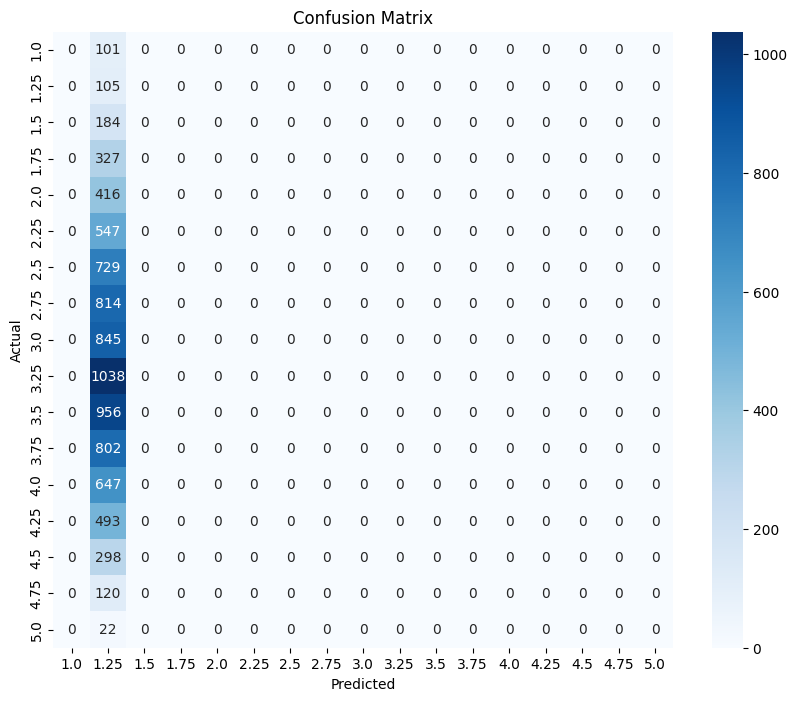

Accuracy: 0.0124
4.3627033


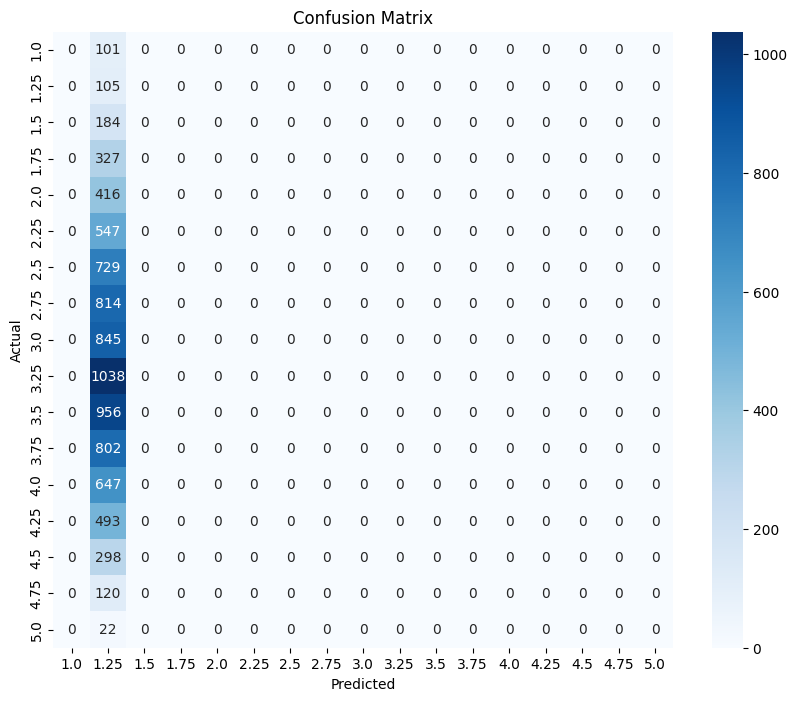

Accuracy: 0.0124


  2%|▏         | 1/50 [00:08<06:38,  8.13s/it]

Epoch [1/50], Loss: 218.7013
--------------------------------------------------


  4%|▍         | 2/50 [00:16<06:30,  8.14s/it]

Epoch [2/50], Loss: 10.2592
--------------------------------------------------
Epoch [3/50], Loss: 9.8190


  6%|▌         | 3/50 [00:25<06:54,  8.83s/it]

Validation: 9.493757247924805
--------------------------------------------------
Epoch [4/50], Loss: 9.4267


  8%|▊         | 4/50 [00:35<07:01,  9.15s/it]

Validation: 9.143227577209473
--------------------------------------------------
Epoch [5/50], Loss: 9.1029


 10%|█         | 5/50 [00:45<06:59,  9.32s/it]

Validation: 8.847967147827148
--------------------------------------------------
Epoch [6/50], Loss: 8.8255


 12%|█▏        | 6/50 [00:54<06:55,  9.44s/it]

Validation: 8.590460777282715
--------------------------------------------------
Epoch [7/50], Loss: 8.5808


 14%|█▍        | 7/50 [01:04<06:49,  9.52s/it]

Validation: 8.360452651977539
--------------------------------------------------
Epoch [8/50], Loss: 8.3603


 16%|█▌        | 8/50 [01:14<06:40,  9.55s/it]

Validation: 8.151593208312988
--------------------------------------------------
Epoch [9/50], Loss: 8.1590


 18%|█▊        | 9/50 [01:23<06:32,  9.58s/it]

Validation: 7.959649085998535
--------------------------------------------------
Epoch [10/50], Loss: 7.9727


 20%|██        | 10/50 [01:33<06:23,  9.60s/it]

Validation: 7.781614303588867
--------------------------------------------------
Epoch [11/50], Loss: 7.7997


 22%|██▏       | 11/50 [01:43<06:15,  9.62s/it]

Validation: 7.6152520179748535
--------------------------------------------------
Epoch [12/50], Loss: 7.6370


 24%|██▍       | 12/50 [01:52<06:06,  9.65s/it]

Validation: 7.458928108215332
--------------------------------------------------
Epoch [13/50], Loss: 7.4842


 26%|██▌       | 13/50 [02:02<05:56,  9.63s/it]

Validation: 7.311266899108887
--------------------------------------------------
Epoch [14/50], Loss: 7.3397


 28%|██▊       | 14/50 [02:12<05:46,  9.63s/it]

Validation: 7.171224117279053
--------------------------------------------------
Epoch [15/50], Loss: 7.2018


 30%|███       | 15/50 [02:21<05:37,  9.65s/it]

Validation: 7.037961483001709
--------------------------------------------------
Epoch [16/50], Loss: 7.0708


 32%|███▏      | 16/50 [02:31<05:30,  9.72s/it]

Validation: 6.910764217376709
--------------------------------------------------
Epoch [17/50], Loss: 6.9454


 34%|███▍      | 17/50 [02:41<05:24,  9.82s/it]

Validation: 6.789048671722412
--------------------------------------------------
Epoch [18/50], Loss: 6.8256


 36%|███▌      | 18/50 [02:51<05:16,  9.88s/it]

Validation: 6.6722893714904785
--------------------------------------------------
Epoch [19/50], Loss: 6.7103


 38%|███▊      | 19/50 [03:01<05:06,  9.88s/it]

Validation: 6.560086250305176
--------------------------------------------------
Epoch [20/50], Loss: 6.5994


 40%|████      | 20/50 [03:11<04:58,  9.97s/it]

Validation: 6.452045917510986
--------------------------------------------------
Epoch [21/50], Loss: 6.4925


 42%|████▏     | 21/50 [03:21<04:50, 10.01s/it]

Validation: 6.347840309143066
--------------------------------------------------
Epoch [22/50], Loss: 6.3893


 44%|████▍     | 22/50 [03:32<04:42, 10.08s/it]

Validation: 6.247193336486816
--------------------------------------------------
Epoch [23/50], Loss: 6.2896


 46%|████▌     | 23/50 [03:42<04:32, 10.10s/it]

Validation: 6.149860858917236
--------------------------------------------------
Epoch [24/50], Loss: 6.1935


 48%|████▊     | 24/50 [03:52<04:23, 10.13s/it]

Validation: 6.055602073669434
--------------------------------------------------
Epoch [25/50], Loss: 6.0999


 50%|█████     | 25/50 [04:02<04:12, 10.11s/it]

Validation: 5.964234828948975
--------------------------------------------------
Epoch [26/50], Loss: 6.0091


 52%|█████▏    | 26/50 [04:12<04:01, 10.07s/it]

Validation: 5.875574111938477
--------------------------------------------------
Epoch [27/50], Loss: 5.9212


 54%|█████▍    | 27/50 [04:22<03:51, 10.08s/it]

Validation: 5.789460182189941
--------------------------------------------------
Epoch [28/50], Loss: 5.8357


 56%|█████▌    | 28/50 [04:32<03:41, 10.09s/it]

Validation: 5.705749034881592
--------------------------------------------------
Epoch [29/50], Loss: 5.7524


 58%|█████▊    | 29/50 [04:42<03:30, 10.04s/it]

Validation: 5.624298095703125
--------------------------------------------------
Epoch [30/50], Loss: 5.6716


 60%|██████    | 30/50 [04:52<03:20, 10.02s/it]

Validation: 5.54499626159668
--------------------------------------------------
Epoch [31/50], Loss: 5.5927


 62%|██████▏   | 31/50 [05:02<03:11, 10.05s/it]

Validation: 5.467724800109863
--------------------------------------------------
Epoch [32/50], Loss: 5.5159


 64%|██████▍   | 32/50 [05:12<03:01, 10.06s/it]

Validation: 5.392387866973877
--------------------------------------------------
Epoch [33/50], Loss: 5.4408


 66%|██████▌   | 33/50 [05:22<02:50, 10.03s/it]

Validation: 5.31889533996582
--------------------------------------------------
Epoch [34/50], Loss: 5.3675


 68%|██████▊   | 34/50 [05:32<02:39,  9.98s/it]

Validation: 5.24716329574585
--------------------------------------------------
Epoch [35/50], Loss: 5.2963


 70%|███████   | 35/50 [05:42<02:29,  9.96s/it]

Validation: 5.177095890045166
--------------------------------------------------
Epoch [36/50], Loss: 5.2265


 72%|███████▏  | 36/50 [05:52<02:19,  9.94s/it]

Validation: 5.10863733291626
--------------------------------------------------
Epoch [37/50], Loss: 5.1582


 74%|███████▍  | 37/50 [06:02<02:09,  9.94s/it]

Validation: 5.041708469390869
--------------------------------------------------
Epoch [38/50], Loss: 5.0915


 76%|███████▌  | 38/50 [06:12<02:00, 10.00s/it]

Validation: 4.9762468338012695
--------------------------------------------------
Epoch [39/50], Loss: 5.0264


 78%|███████▊  | 39/50 [06:22<01:49,  9.99s/it]

Validation: 4.912191867828369
--------------------------------------------------
Epoch [40/50], Loss: 4.9625


 80%|████████  | 40/50 [06:32<01:39,  9.98s/it]

Validation: 4.849490642547607
--------------------------------------------------
Epoch [41/50], Loss: 4.8998


 82%|████████▏ | 41/50 [06:42<01:30, 10.01s/it]

Validation: 4.788092613220215
--------------------------------------------------
Epoch [42/50], Loss: 4.8384


 84%|████████▍ | 42/50 [06:52<01:20, 10.04s/it]

Validation: 4.727946758270264
--------------------------------------------------
Epoch [43/50], Loss: 4.7786


 86%|████████▌ | 43/50 [07:02<01:10, 10.01s/it]

Validation: 4.669005393981934
--------------------------------------------------
Epoch [44/50], Loss: 4.7198


 88%|████████▊ | 44/50 [07:12<00:59,  9.99s/it]

Validation: 4.6112236976623535
--------------------------------------------------
Epoch [45/50], Loss: 4.6621


 90%|█████████ | 45/50 [07:22<00:50, 10.03s/it]

Validation: 4.554564476013184
--------------------------------------------------
Epoch [46/50], Loss: 4.6054


 92%|█████████▏| 46/50 [07:32<00:40, 10.03s/it]

Validation: 4.498989105224609
--------------------------------------------------
Epoch [47/50], Loss: 4.5498


 94%|█████████▍| 47/50 [07:42<00:29, 10.00s/it]

Validation: 4.444462776184082
--------------------------------------------------
Epoch [48/50], Loss: 4.4955


 96%|█████████▌| 48/50 [07:52<00:20, 10.00s/it]

Validation: 4.390946865081787
--------------------------------------------------
Epoch [49/50], Loss: 4.4420


 98%|█████████▊| 49/50 [08:02<00:10, 10.02s/it]

Validation: 4.338408470153809
--------------------------------------------------
Epoch [50/50], Loss: 4.3894


100%|██████████| 50/50 [08:12<00:00,  9.85s/it]

Validation: 4.286823272705078
--------------------------------------------------


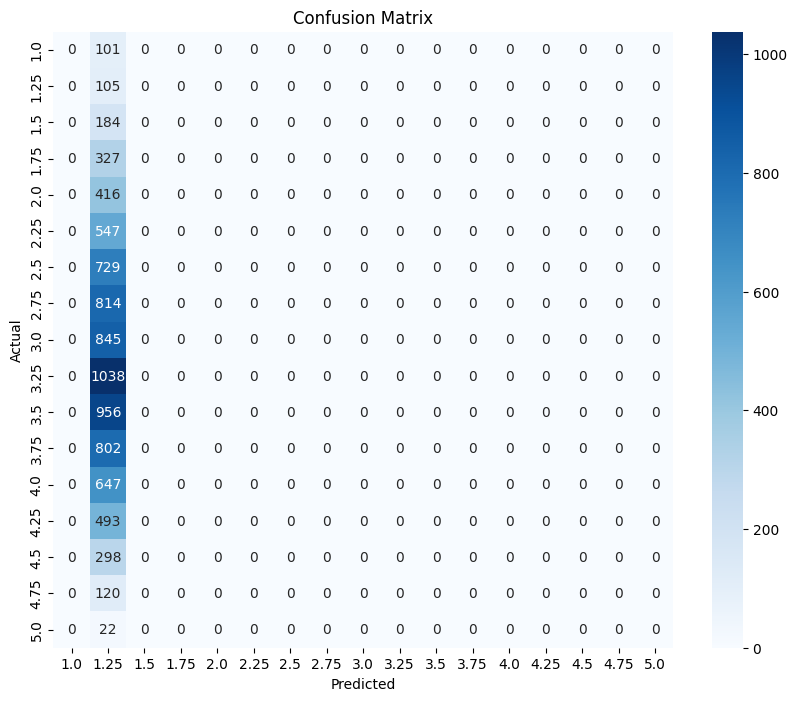

Accuracy: 0.0124
4.362825


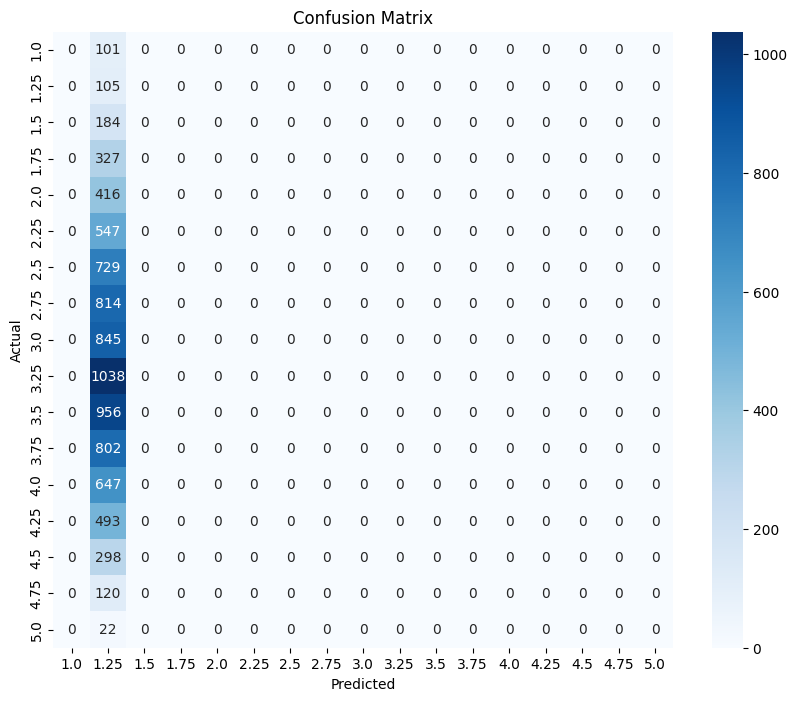

Accuracy: 0.0124


  2%|▏         | 1/50 [00:08<06:47,  8.31s/it]

Epoch [1/50], Loss: 3.8604
--------------------------------------------------


  4%|▍         | 2/50 [00:16<06:39,  8.33s/it]

Epoch [2/50], Loss: 0.9332
--------------------------------------------------
Epoch [3/50], Loss: 0.7773


  6%|▌         | 3/50 [00:26<07:02,  8.99s/it]

Validation: 0.7879580855369568
--------------------------------------------------
Epoch [4/50], Loss: 0.6980


  8%|▊         | 4/50 [00:36<07:09,  9.33s/it]

Validation: 0.6204487085342407
--------------------------------------------------
Epoch [5/50], Loss: 0.6620


 10%|█         | 5/50 [00:46<07:10,  9.57s/it]

Validation: 0.5865225791931152
--------------------------------------------------
Epoch [6/50], Loss: 0.5967


 12%|█▏        | 6/50 [00:56<07:06,  9.70s/it]

Validation: 0.6146807074546814
--------------------------------------------------
Epoch [7/50], Loss: 0.5902


 14%|█▍        | 7/50 [01:06<06:58,  9.74s/it]

Validation: 0.5405572056770325
--------------------------------------------------
Epoch [8/50], Loss: 0.5755


 16%|█▌        | 8/50 [01:15<06:51,  9.81s/it]

Validation: 0.5734352469444275
--------------------------------------------------
Epoch [9/50], Loss: 0.5554


 18%|█▊        | 9/50 [01:25<06:43,  9.85s/it]

Validation: 0.5163357853889465
--------------------------------------------------
Epoch [10/50], Loss: 0.5490


 20%|██        | 10/50 [01:35<06:34,  9.85s/it]

Validation: 0.5066405534744263
--------------------------------------------------
Epoch [11/50], Loss: 0.5301


 22%|██▏       | 11/50 [01:45<06:23,  9.84s/it]

Validation: 0.49911534786224365
--------------------------------------------------
Epoch [12/50], Loss: 0.5317


 24%|██▍       | 12/50 [01:55<06:15,  9.89s/it]

Validation: 0.554538369178772
--------------------------------------------------
Epoch [13/50], Loss: 0.5240


 26%|██▌       | 13/50 [02:05<06:06,  9.91s/it]

Validation: 0.500967800617218
--------------------------------------------------
Epoch [14/50], Loss: 0.5120


 28%|██▊       | 14/50 [02:15<05:56,  9.90s/it]

Validation: 0.5044184327125549
--------------------------------------------------
Epoch [15/50], Loss: 0.5174


 30%|███       | 15/50 [02:25<05:47,  9.91s/it]

Validation: 0.49452948570251465
--------------------------------------------------
Epoch [16/50], Loss: 0.4935


 32%|███▏      | 16/50 [02:35<05:39,  9.98s/it]

Validation: 0.5133093595504761
--------------------------------------------------
Epoch [17/50], Loss: 0.5063


 34%|███▍      | 17/50 [02:45<05:29, 10.00s/it]

Validation: 0.5122992992401123
--------------------------------------------------
Epoch [18/50], Loss: 0.4921


 36%|███▌      | 18/50 [02:55<05:19,  9.99s/it]

Validation: 0.47331276535987854
--------------------------------------------------
Epoch [19/50], Loss: 0.4795


 38%|███▊      | 19/50 [03:05<05:09,  9.97s/it]

Validation: 0.47866126894950867
--------------------------------------------------
Epoch [20/50], Loss: 0.4801


 40%|████      | 20/50 [03:15<04:58,  9.97s/it]

Validation: 0.4719395935535431
--------------------------------------------------
Epoch [21/50], Loss: 0.4706


 42%|████▏     | 21/50 [03:25<04:48,  9.96s/it]

Validation: 0.49295204877853394
--------------------------------------------------
Epoch [22/50], Loss: 0.4722


 44%|████▍     | 22/50 [03:35<04:38,  9.96s/it]

Validation: 0.4867434501647949
--------------------------------------------------
Epoch [23/50], Loss: 0.4708


 46%|████▌     | 23/50 [03:45<04:30, 10.01s/it]

Validation: 0.47333186864852905
--------------------------------------------------
Epoch [24/50], Loss: 0.4640


 48%|████▊     | 24/50 [03:55<04:21, 10.06s/it]

Validation: 0.4682075083255768
--------------------------------------------------
Epoch [25/50], Loss: 0.4668


 50%|█████     | 25/50 [04:05<04:10, 10.03s/it]

Validation: 0.4620175361633301
--------------------------------------------------
Epoch [26/50], Loss: 0.4534


 52%|█████▏    | 26/50 [04:15<04:01, 10.05s/it]

Validation: 0.45682504773139954
--------------------------------------------------
Epoch [27/50], Loss: 0.4500


 54%|█████▍    | 27/50 [04:25<03:51, 10.08s/it]

Validation: 0.47192904353141785
--------------------------------------------------
Epoch [28/50], Loss: 0.4558


 56%|█████▌    | 28/50 [04:35<03:40, 10.04s/it]

Validation: 0.4771808683872223
--------------------------------------------------
Epoch [29/50], Loss: 0.4451


 58%|█████▊    | 29/50 [04:45<03:30, 10.04s/it]

Validation: 0.45528122782707214
--------------------------------------------------
Epoch [30/50], Loss: 0.4364


 60%|██████    | 30/50 [04:55<03:21, 10.07s/it]

Validation: 0.45139262080192566
--------------------------------------------------
Epoch [31/50], Loss: 0.4478


 62%|██████▏   | 31/50 [05:06<03:11, 10.07s/it]

Validation: 0.45096948742866516
--------------------------------------------------
Epoch [32/50], Loss: 0.4331


 64%|██████▍   | 32/50 [05:16<03:00, 10.04s/it]

Validation: 0.4492054879665375
--------------------------------------------------
Epoch [33/50], Loss: 0.4344


 66%|██████▌   | 33/50 [05:26<02:51, 10.10s/it]

Validation: 0.4576123058795929
--------------------------------------------------
Epoch [34/50], Loss: 0.4379


 68%|██████▊   | 34/50 [05:36<02:41, 10.11s/it]

Validation: 0.46117880940437317
--------------------------------------------------
Epoch [35/50], Loss: 0.4303


 70%|███████   | 35/50 [05:46<02:31, 10.09s/it]

Validation: 0.4471052885055542
--------------------------------------------------
Epoch [36/50], Loss: 0.4258


 72%|███████▏  | 36/50 [05:56<02:20, 10.03s/it]

Validation: 0.44090601801872253
--------------------------------------------------
Epoch [37/50], Loss: 0.4187


 74%|███████▍  | 37/50 [06:15<02:47, 12.89s/it]

Validation: 0.441290944814682
--------------------------------------------------
Epoch [38/50], Loss: 0.4159


 76%|███████▌  | 38/50 [06:27<02:31, 12.61s/it]

Validation: 0.4464380145072937
--------------------------------------------------
Epoch [39/50], Loss: 0.4203


 78%|███████▊  | 39/50 [06:39<02:15, 12.28s/it]

Validation: 0.44985753297805786
--------------------------------------------------
Epoch [40/50], Loss: 0.4187


 80%|████████  | 40/50 [06:51<02:01, 12.16s/it]

Validation: 0.4464418888092041
--------------------------------------------------
Epoch [41/50], Loss: 0.4135


 82%|████████▏ | 41/50 [07:03<01:48, 12.06s/it]

Validation: 0.4458819031715393
--------------------------------------------------
Epoch [42/50], Loss: 0.4129


 84%|████████▍ | 42/50 [07:14<01:35, 11.96s/it]

Validation: 0.44019249081611633
--------------------------------------------------
Epoch [43/50], Loss: 0.4095


 86%|████████▌ | 43/50 [07:26<01:23, 11.94s/it]

Validation: 0.43778613209724426
--------------------------------------------------
Epoch [44/50], Loss: 0.4076


 88%|████████▊ | 44/50 [07:38<01:11, 11.88s/it]

Validation: 0.4379996955394745
--------------------------------------------------
Epoch [45/50], Loss: 0.4085


 90%|█████████ | 45/50 [07:50<00:59, 11.83s/it]

Validation: 0.4390859305858612
--------------------------------------------------
Epoch [46/50], Loss: 0.4005


 92%|█████████▏| 46/50 [08:01<00:47, 11.79s/it]

Validation: 0.4388524293899536
--------------------------------------------------
Epoch [47/50], Loss: 0.4052


 94%|█████████▍| 47/50 [08:13<00:35, 11.81s/it]

Validation: 0.44870465993881226
--------------------------------------------------
Epoch [48/50], Loss: 0.4052


 96%|█████████▌| 48/50 [08:26<00:23, 11.98s/it]

Validation: 0.4500894248485565
--------------------------------------------------
Epoch [49/50], Loss: 0.4031


 98%|█████████▊| 49/50 [08:37<00:11, 11.92s/it]

Validation: 0.4435212314128876
--------------------------------------------------
Epoch [50/50], Loss: 0.4003


100%|██████████| 50/50 [08:49<00:00, 10.59s/it]

Validation: 0.43715059757232666
--------------------------------------------------


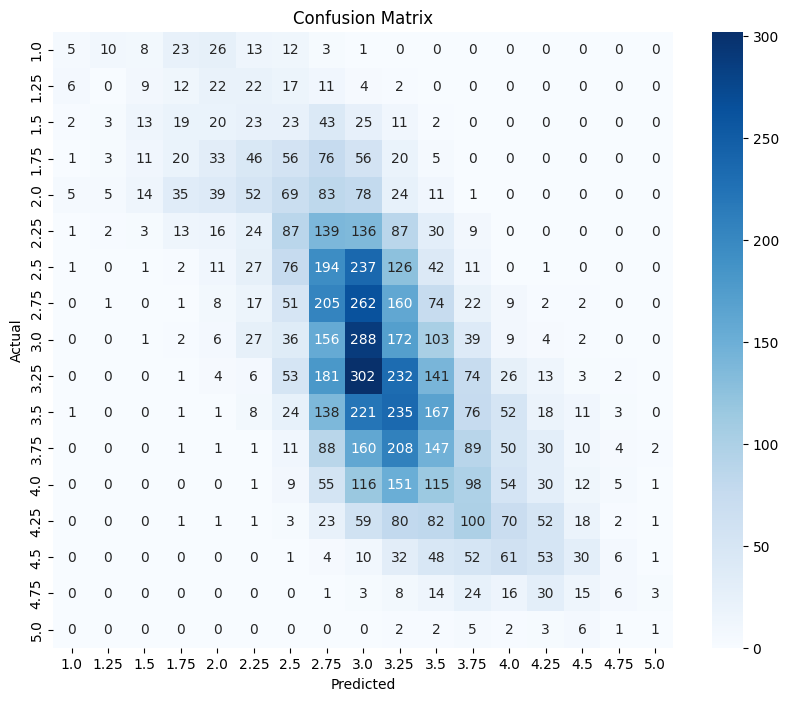

Accuracy: 0.1541
0.39573103


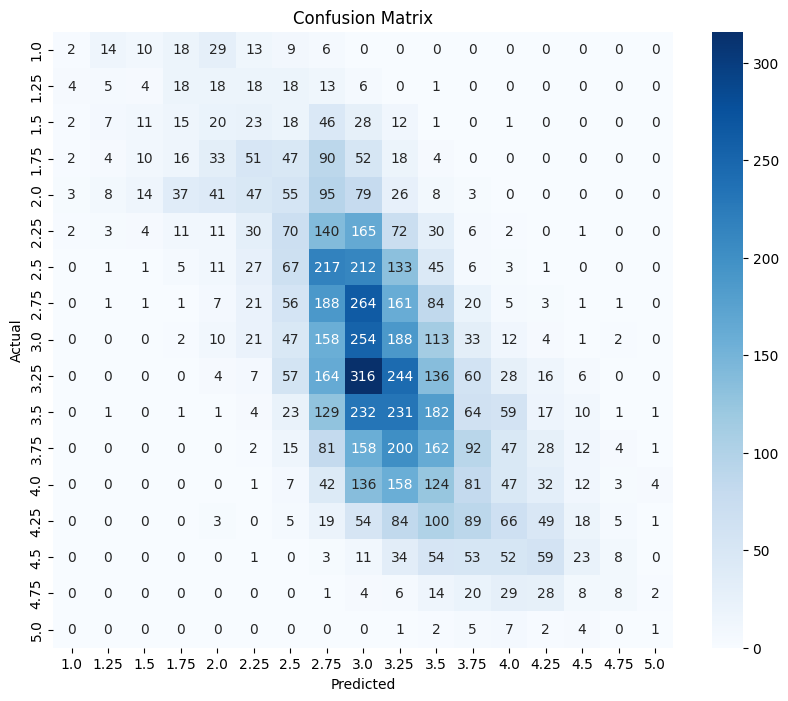

Accuracy: 0.1492


  2%|▏         | 1/50 [00:09<07:55,  9.70s/it]

Epoch [1/50], Loss: 3.8617
--------------------------------------------------


  4%|▍         | 2/50 [00:19<07:50,  9.79s/it]

Epoch [2/50], Loss: 0.9334
--------------------------------------------------
Epoch [3/50], Loss: 0.7784


  6%|▌         | 3/50 [00:31<08:22, 10.68s/it]

Validation: 0.7795759439468384
--------------------------------------------------
Epoch [4/50], Loss: 0.6992


  8%|▊         | 4/50 [00:42<08:29, 11.07s/it]

Validation: 0.6183747053146362
--------------------------------------------------
Epoch [5/50], Loss: 0.6617


 10%|█         | 5/50 [00:54<08:30, 11.34s/it]

Validation: 0.5926091074943542
--------------------------------------------------
Epoch [6/50], Loss: 0.5971


 12%|█▏        | 6/50 [01:06<08:24, 11.47s/it]

Validation: 0.608414351940155
--------------------------------------------------
Epoch [7/50], Loss: 0.5914


 14%|█▍        | 7/50 [01:18<08:16, 11.55s/it]

Validation: 0.5438705086708069
--------------------------------------------------
Epoch [8/50], Loss: 0.5743


 16%|█▌        | 8/50 [01:30<08:19, 11.90s/it]

Validation: 0.5770049691200256
--------------------------------------------------
Epoch [9/50], Loss: 0.5577


 18%|█▊        | 9/50 [01:41<07:46, 11.38s/it]

Validation: 0.5212839245796204
--------------------------------------------------
Epoch [10/50], Loss: 0.5481


 20%|██        | 10/50 [01:51<07:20, 11.00s/it]

Validation: 0.5115965604782104
--------------------------------------------------
Epoch [11/50], Loss: 0.5303


 22%|██▏       | 11/50 [02:01<07:00, 10.78s/it]

Validation: 0.5025160908699036
--------------------------------------------------
Epoch [12/50], Loss: 0.5313


 24%|██▍       | 12/50 [02:11<06:39, 10.52s/it]

Validation: 0.562648594379425
--------------------------------------------------
Epoch [13/50], Loss: 0.5236


 26%|██▌       | 13/50 [02:21<06:20, 10.27s/it]

Validation: 0.5069084763526917
--------------------------------------------------
Epoch [14/50], Loss: 0.5118


 28%|██▊       | 14/50 [02:30<06:03, 10.08s/it]

Validation: 0.505135715007782
--------------------------------------------------
Epoch [15/50], Loss: 0.5149


 30%|███       | 15/50 [02:40<05:49,  9.98s/it]

Validation: 0.4943913519382477
--------------------------------------------------
Epoch [16/50], Loss: 0.4931


 32%|███▏      | 16/50 [02:50<05:36,  9.90s/it]

Validation: 0.5192009806632996
--------------------------------------------------
Epoch [17/50], Loss: 0.5050


 34%|███▍      | 17/50 [02:59<05:23,  9.80s/it]

Validation: 0.5183525085449219
--------------------------------------------------
Epoch [18/50], Loss: 0.4898


 36%|███▌      | 18/50 [03:09<05:12,  9.76s/it]

Validation: 0.47556138038635254
--------------------------------------------------
Epoch [19/50], Loss: 0.4791


 38%|███▊      | 19/50 [03:19<05:04,  9.81s/it]

Validation: 0.4814593493938446
--------------------------------------------------
Epoch [20/50], Loss: 0.4791


 40%|████      | 20/50 [03:29<04:53,  9.78s/it]

Validation: 0.47234466671943665
--------------------------------------------------
Epoch [21/50], Loss: 0.4683


 42%|████▏     | 21/50 [03:38<04:42,  9.73s/it]

Validation: 0.4948521852493286
--------------------------------------------------
Epoch [22/50], Loss: 0.4718


 44%|████▍     | 22/50 [03:48<04:33,  9.75s/it]

Validation: 0.491566002368927
--------------------------------------------------
Epoch [23/50], Loss: 0.4710


 46%|████▌     | 23/50 [03:58<04:23,  9.76s/it]

Validation: 0.4787611663341522
--------------------------------------------------
Epoch [24/50], Loss: 0.4618


 48%|████▊     | 24/50 [04:06<04:03,  9.35s/it]

Validation: 0.4707947075366974
--------------------------------------------------
Epoch [25/50], Loss: 0.4646


 50%|█████     | 25/50 [04:15<03:50,  9.24s/it]

Validation: 0.46508824825286865
--------------------------------------------------
Epoch [26/50], Loss: 0.4542


 52%|█████▏    | 26/50 [04:25<03:47,  9.46s/it]

Validation: 0.4579186737537384
--------------------------------------------------
Epoch [27/50], Loss: 0.4490


 54%|█████▍    | 27/50 [04:35<03:39,  9.56s/it]

Validation: 0.4693737030029297
--------------------------------------------------
Epoch [28/50], Loss: 0.4541


 56%|█████▌    | 28/50 [04:45<03:32,  9.64s/it]

Validation: 0.47698137164115906
--------------------------------------------------
Epoch [29/50], Loss: 0.4449


 58%|█████▊    | 29/50 [04:55<03:25,  9.78s/it]

Validation: 0.4576185345649719
--------------------------------------------------
Epoch [30/50], Loss: 0.4357


 60%|██████    | 30/50 [05:05<03:15,  9.77s/it]

Validation: 0.45178234577178955
--------------------------------------------------
Epoch [31/50], Loss: 0.4456


 62%|██████▏   | 31/50 [05:15<03:06,  9.82s/it]

Validation: 0.45428165793418884
--------------------------------------------------
Epoch [32/50], Loss: 0.4339


 64%|██████▍   | 32/50 [05:24<02:56,  9.80s/it]

Validation: 0.4540589153766632
--------------------------------------------------
Epoch [33/50], Loss: 0.4344


 66%|██████▌   | 33/50 [05:35<02:48,  9.93s/it]

Validation: 0.4593249261379242
--------------------------------------------------
Epoch [34/50], Loss: 0.4357


 68%|██████▊   | 34/50 [05:45<02:40, 10.00s/it]

Validation: 0.46107906103134155
--------------------------------------------------
Epoch [35/50], Loss: 0.4290


 70%|███████   | 35/50 [05:55<02:29,  9.94s/it]

Validation: 0.4484151303768158
--------------------------------------------------
Epoch [36/50], Loss: 0.4258


 72%|███████▏  | 36/50 [06:05<02:21, 10.10s/it]

Validation: 0.44139283895492554
--------------------------------------------------
Epoch [37/50], Loss: 0.4188


 74%|███████▍  | 37/50 [06:15<02:11, 10.11s/it]

Validation: 0.4420630633831024
--------------------------------------------------
Epoch [38/50], Loss: 0.4154


 76%|███████▌  | 38/50 [06:25<02:00, 10.04s/it]

Validation: 0.4478149712085724
--------------------------------------------------
Epoch [39/50], Loss: 0.4190


 78%|███████▊  | 39/50 [06:35<01:49,  9.92s/it]

Validation: 0.4487156867980957
--------------------------------------------------
Epoch [40/50], Loss: 0.4180


 80%|████████  | 40/50 [06:44<01:38,  9.85s/it]

Validation: 0.4473994970321655
--------------------------------------------------
Epoch [41/50], Loss: 0.4152


 82%|████████▏ | 41/50 [06:54<01:27,  9.76s/it]

Validation: 0.4499206840991974
--------------------------------------------------
Epoch [42/50], Loss: 0.4148


 84%|████████▍ | 42/50 [07:03<01:17,  9.70s/it]

Validation: 0.44122958183288574
--------------------------------------------------
Epoch [43/50], Loss: 0.4080


 86%|████████▌ | 43/50 [07:13<01:07,  9.68s/it]

Validation: 0.4377792775630951
--------------------------------------------------
Epoch [44/50], Loss: 0.4064


 88%|████████▊ | 44/50 [07:23<00:58,  9.73s/it]

Validation: 0.43860945105552673
--------------------------------------------------
Epoch [45/50], Loss: 0.4099


 90%|█████████ | 45/50 [07:33<00:48,  9.80s/it]

Validation: 0.43745318055152893
--------------------------------------------------
Epoch [46/50], Loss: 0.4009


 92%|█████████▏| 46/50 [07:43<00:39,  9.79s/it]

Validation: 0.43341705203056335
--------------------------------------------------
Epoch [47/50], Loss: 0.4041


 94%|█████████▍| 47/50 [07:52<00:29,  9.77s/it]

Validation: 0.4411861002445221
--------------------------------------------------
Epoch [48/50], Loss: 0.4046


 96%|█████████▌| 48/50 [08:02<00:19,  9.85s/it]

Validation: 0.44454193115234375
--------------------------------------------------
Epoch [49/50], Loss: 0.4032


 98%|█████████▊| 49/50 [08:12<00:09,  9.81s/it]

Validation: 0.4411419630050659
--------------------------------------------------
Epoch [50/50], Loss: 0.4016


100%|██████████| 50/50 [08:22<00:00, 10.05s/it]

Validation: 0.43820199370384216
--------------------------------------------------


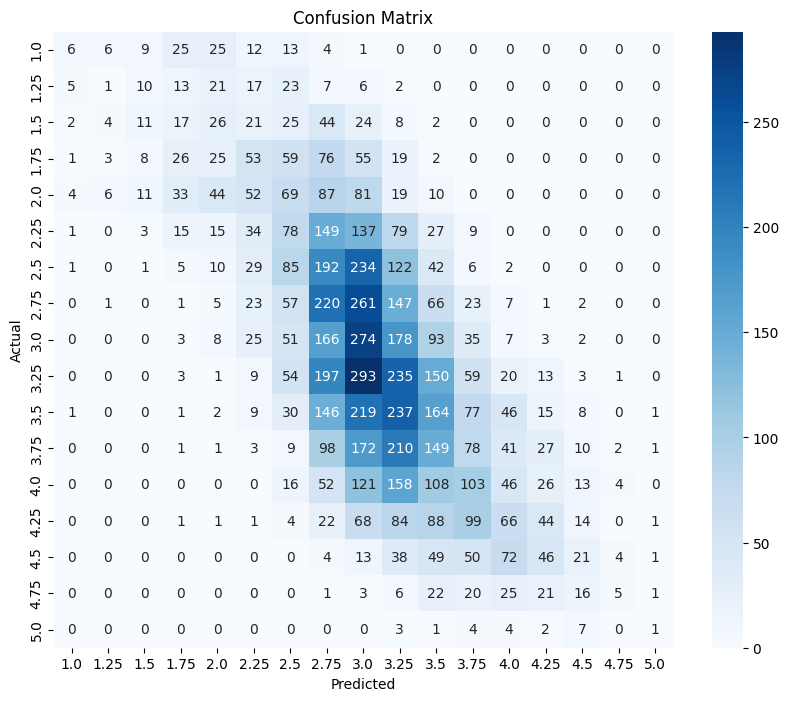

Accuracy: 0.1534
0.3972755


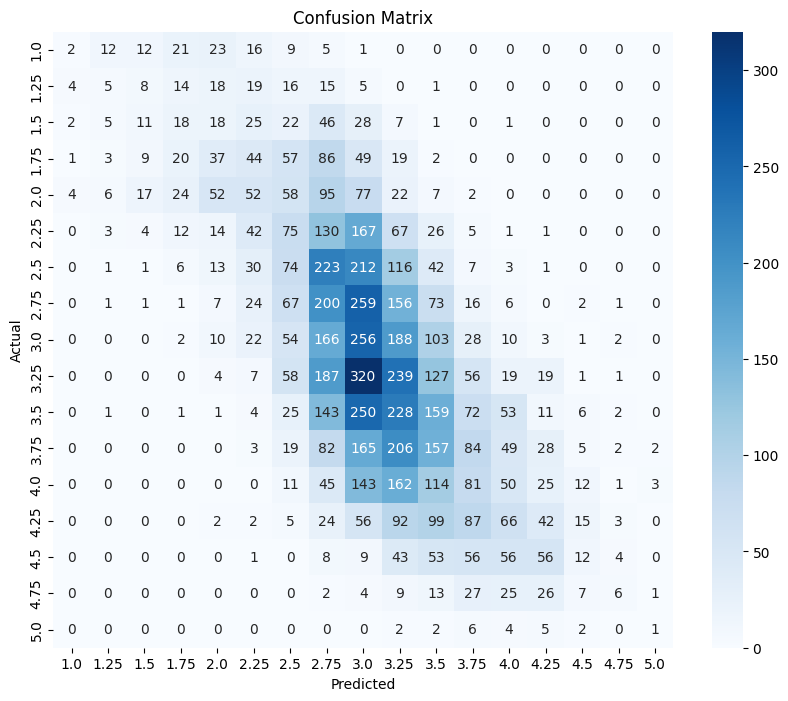

Accuracy: 0.1486
Learning Rate	Weight Decay	MSE
0.001		0.0001		0.39983996748924255
0.001		0.001		0.39824753999710083
0.01		0.0001		4.3628249168396
0.01		0.001		4.362703323364258


In [9]:
# Define learning rates and weight decays to search
learning_rates = [ 0.01, 0.001]
weight_decays = [ 0.001, 0.0001]

# Dictionary to store MSE values for each combination
mse_results = {}

# Iterate over each combination of hyperparameters
for lr in learning_rates:
    for weight_decay in weight_decays:
        # Create the model and optimizer with the current hyperparameters
        modelCNN = CNN().to(device)
        optimizer = optim.Adagrad(modelCNN.parameters(), lr=lr, weight_decay=weight_decay)
        
        # Train the model
        train_model(modelCNN, optimizer, num_epochs=50)
        
        # Evaluate the model
        mse = evaluate_model(modelCNN, train_loader, conf=True)
        
        # Store the MSE value for the current combination of hyperparameters
        mse_results[(lr, weight_decay)] = mse

# Print the MSE values in a table
print("Learning Rate\tWeight Decay\tMSE")
for lr, weight_decay in sorted(mse_results.keys()):
    mse = mse_results[(lr, weight_decay)]
    print(f"{lr}\t\t{weight_decay}\t\t{mse}")

# Official Test Data